In [1]:
import glob
import numpy as np
from scipy.signal import butter, lfilter
from scipy.stats import linregress
from scipy.signal import butter, sosfilt, sosfreqz
import matplotlib.pyplot as plt

# Reading data

In [2]:
sigs = []
titles = []
time = []
for file in glob.glob("lobna-signals/*"):    
    titles.append(file.split("/")[-1])
    with open(file, "r") as f:
        lines = f.readlines()
        signal = []
        time_2 = []
        for i, l in enumerate(lines):
            signal.append(int(l.split(',')[1]))
            time_2.append(int(float(l.split(',')[0])))
        sigs.append(np.array(signal))
        time.append(np.array(time_2))

In [101]:
def visualize_sigs(signals, titles = titles, figsize=(20, 10)):
    fig, ax = plt.subplots(len(signals), 1, figsize=figsize)
    for i in range(len(signals)):
        ax[i].plot(signals[i])
        ax[i].set_title(titles[i])
    plt.tight_layout()
    
def visualize_binary_sigs(binary_signals, signals, titles = titles, figsize=(20, 10)):
    fig, ax = plt.subplots(len(signals), 1, figsize=figsize)
    for i in range(len(signals)):
        ax[i].plot(signals[i])
        ax[i].plot(binary_signals[i])
        ax[i].set_title(titles[i])
    plt.tight_layout()
    
def binarize(signals):
    return signals - np.average(signals)

def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y
    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos    

def denoise_TKEO(signal):
    tkeo_sig = (np.square(signal[1:-1]) - signal[:-2] * signal[2:])
    return tkeo_sig

def smoothing_values(frequency_rate = 1000, smooth_precentage = 20):
    smooth_precentage = smooth_precentage
    return int((smooth_precentage/100) * frequency_rate)

def average_moving(sig, wind_size):
    wind_size = int(wind_size)
    ret = np.cumsum(sig, dtype=float)
    ret[wind_size:] = ret[wind_size:] - ret[:-wind_size]
    return np.concatenate((np.zeros(wind_size - 1), ret[wind_size - 1:] / wind_size))

def rectifying(signals, frequency_rate = 1000):
    rect_signal = np.absolute(signals)
    rect_signal = average_moving(rect_signal, frequency_rate / 10)
    return rect_signal

def Smoothing(signal, smoothing_value):
    smooth_signal = []
    #smoothing_value = smoothing_values()
    for i in range(0, len(signal)):
        if smoothing_value < i < len(signal) - smoothing_value:
            smooth_signal.append(np.mean(signal[i - smoothing_value:i + smoothing_value]))
        else:
            smooth_signal.append(0)
    return smooth_signal

def threshold(signal):
    average_sig = np.average(signal)
    std_sig = np.std(signal)
    return average_sig, std_sig

def normReg(thresholdLevel, avg_sig, std_sig , smooth_signal):
    threshold_0_perc_level = (- avg_sig) / float(std_sig)
    threshold_100_perc_level = (max(smooth_signal) - avg_sig) / float(std_sig)
    m, b = linregress([0, 100], [threshold_0_perc_level, threshold_100_perc_level])[:2]
    return m * thresholdLevel + b 

def get_binary_label_sig(signal, threshold):
    binary_signal = []
    for i in range(0, len(signal)):
        if signal[i] >= threshold:
            binary_signal.append(1)
        else:
            binary_signal.append(0)
    return binary_signal

## Binarizing Signals

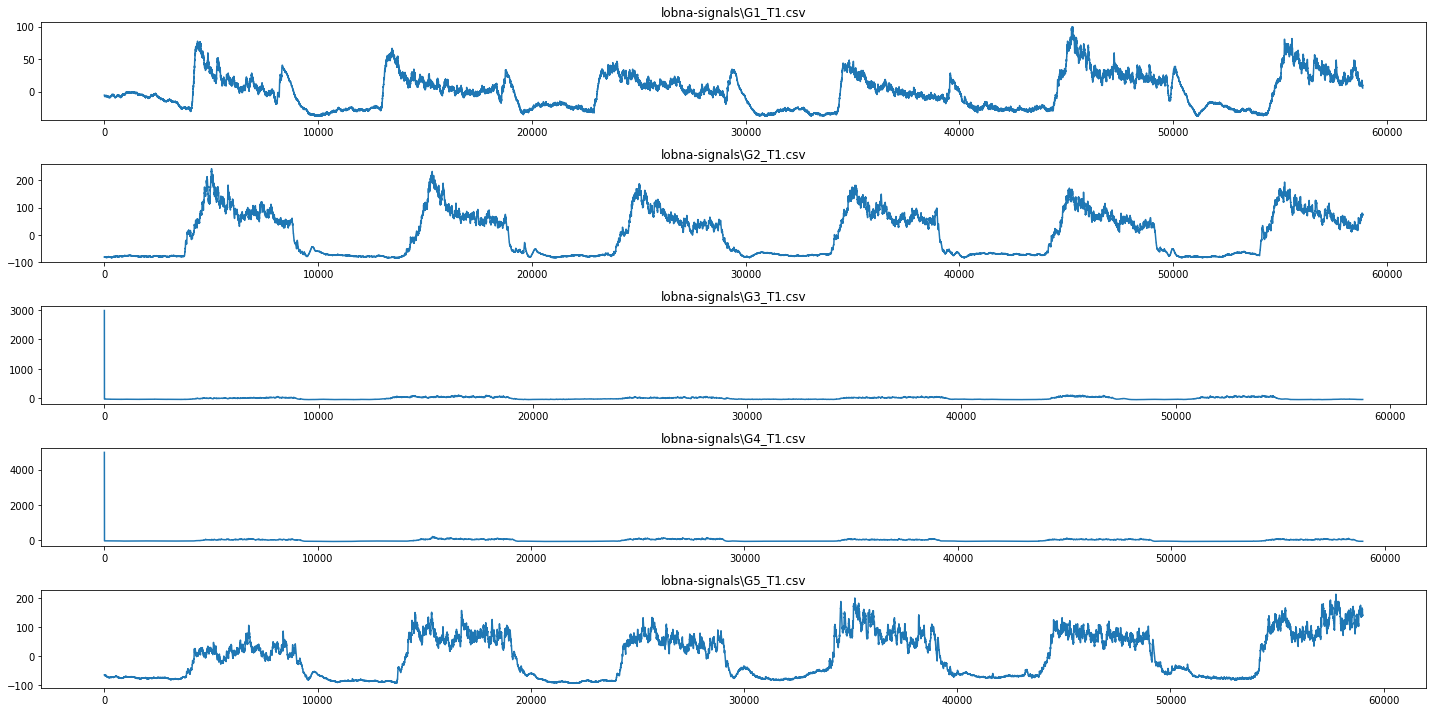

In [4]:
bin_sig = [binarize(sig) for sig in sigs]
visualize_sigs(bin_sig, titles)

# Filtering using Butter bandpass

In [5]:
filt = [butter_bandpass_filter(sig, 30, 300) for sig in bin_sig]
filt = [sig[30:] for sig in filt]
#filt = filt[30:]

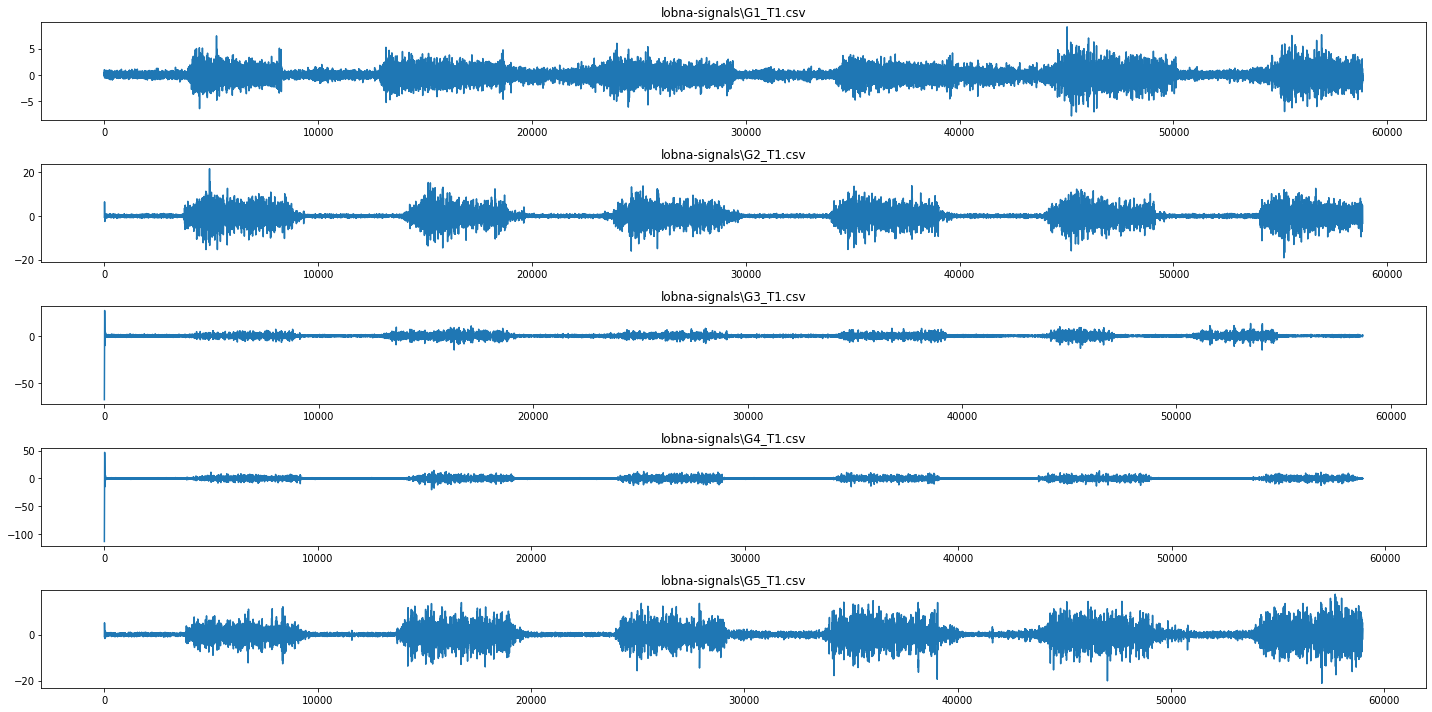

In [6]:
visualize_sigs(filt, titles)

## TKEO

In [24]:
tkeo_sigs = [denoise_TKEO(sig) for sig in filt]

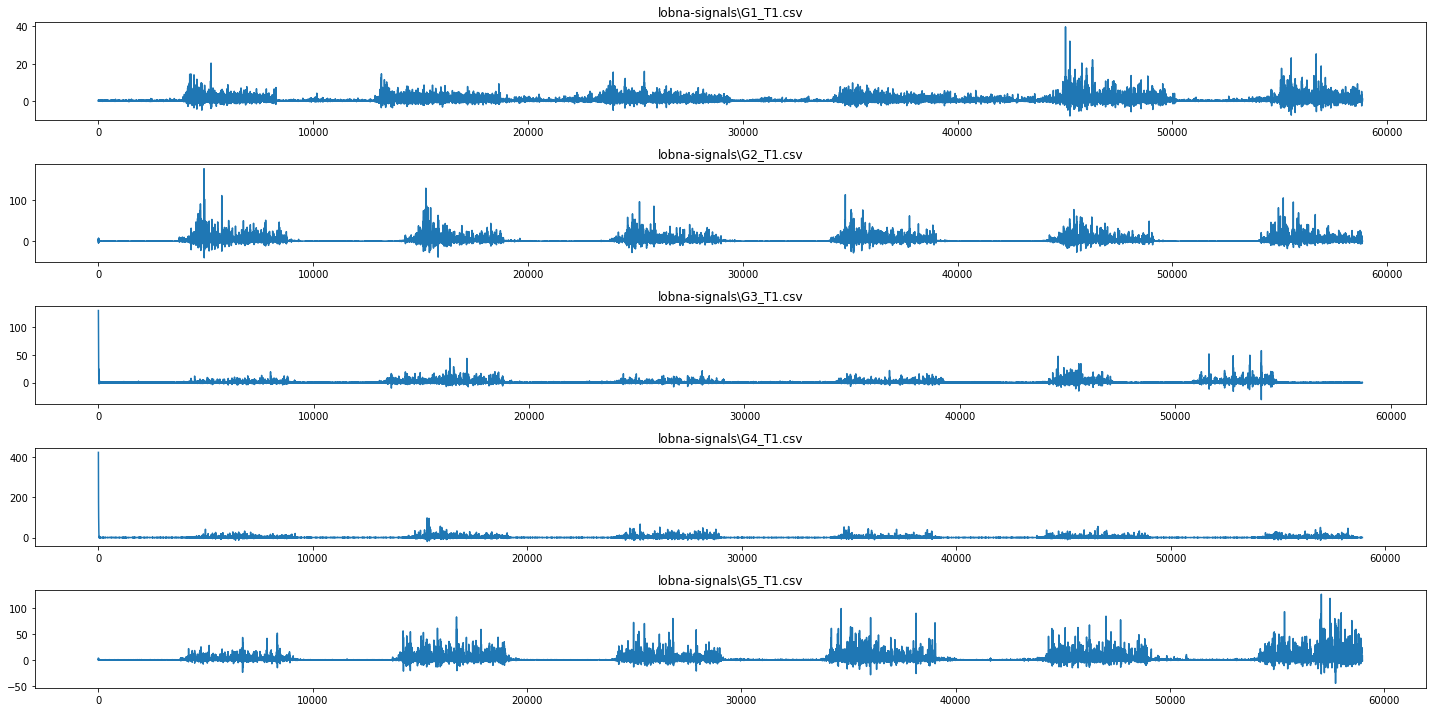

In [27]:
visualize_sigs(tkeo_sigs, titles)

## Rectifying

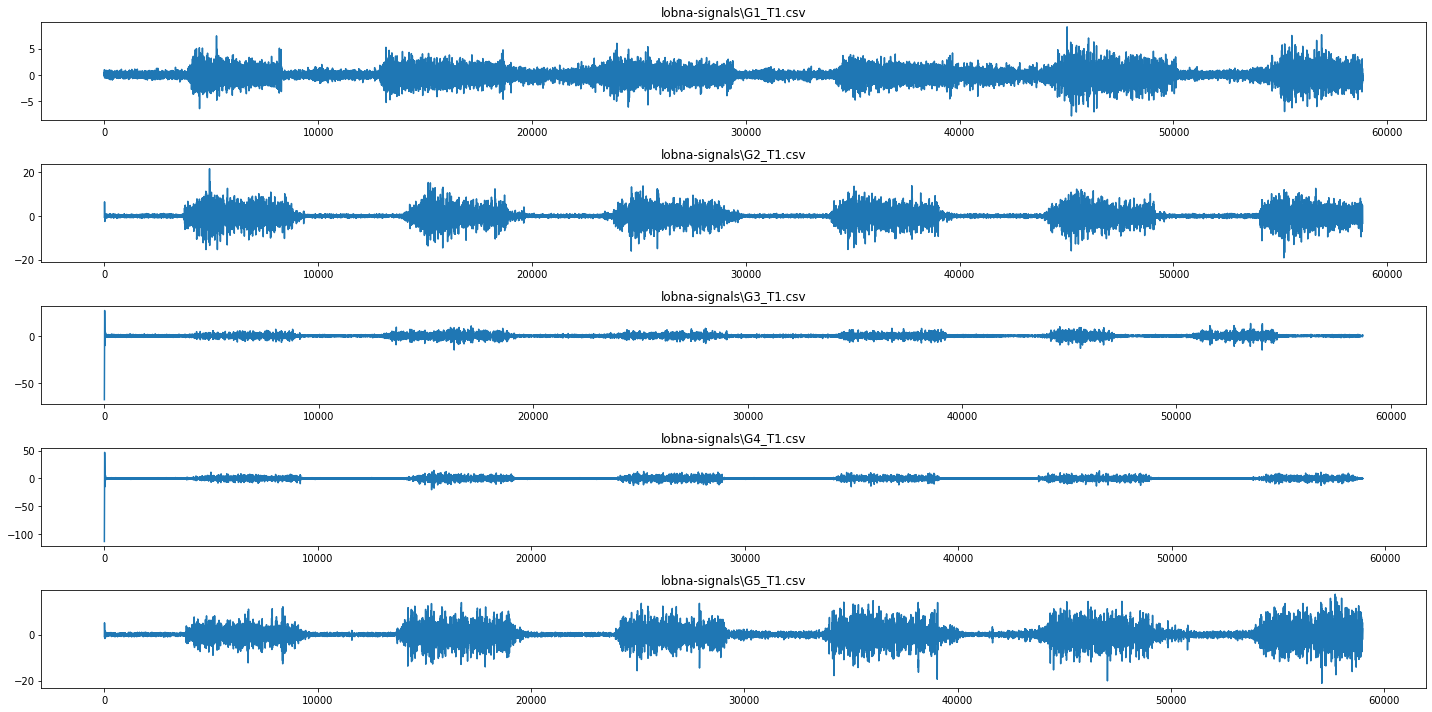

In [28]:
rect_signal = [rectifying(sig) for sig in tkeo_sigs]
visualize_sigs(filt, titles)

## Smoothing

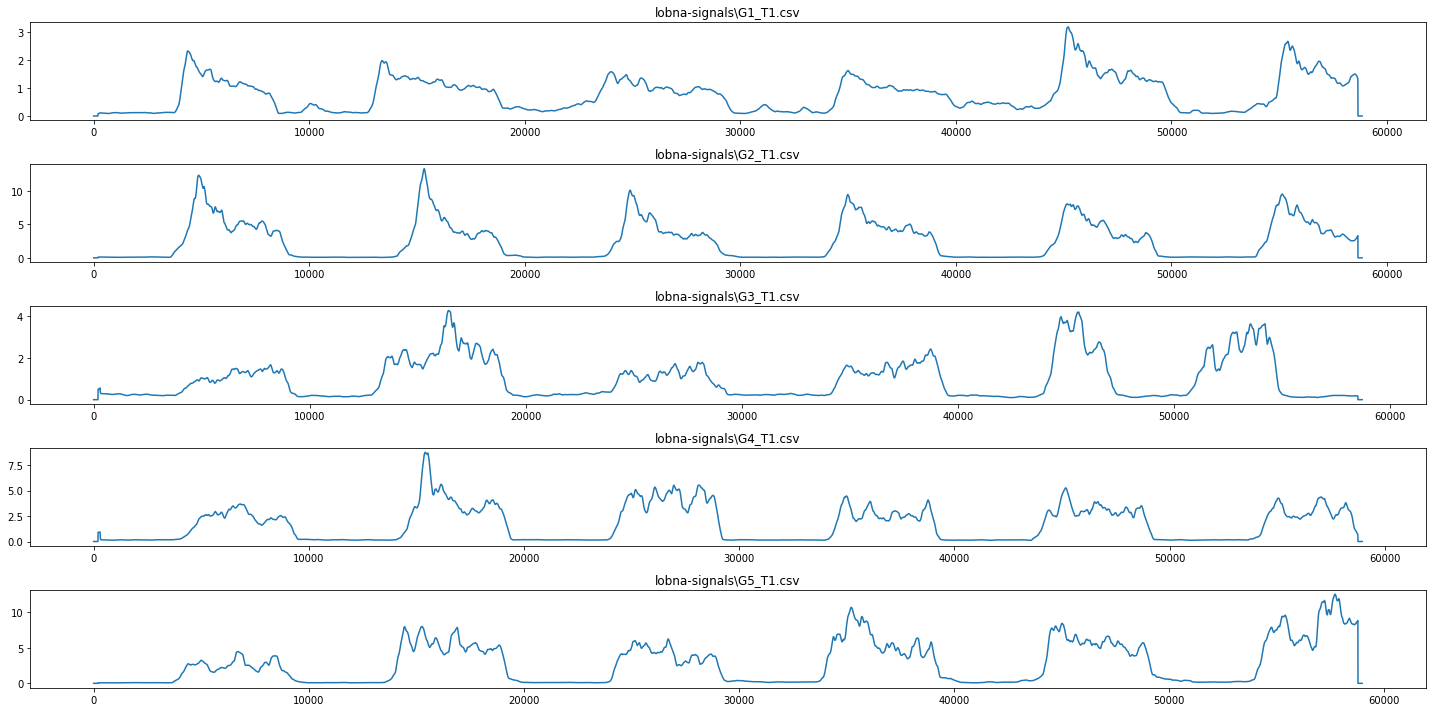

In [41]:
smoothing_value = smoothing_values()
sm_sig = [Smoothing(sig, smoothing_value) for sig in rect_signal]
visualize_sigs(sm_sig, titles) 

## Constant Threshold

In [63]:
avg_sig, std_sig = [], []
for i in filt:
    x,y = threshold(i)
    avg_sig.append(x)
    std_sig.append(y)

## Normalization Regression

In [80]:
threshold_level = 10 # % Relative to the average value of the smoothed signal
threshold_level_norm_10 = [normReg(threshold_level, avg, std, sig) for avg, std, sig in zip(avg_sig, std_sig, sm_sig)]

threshold_level = 80 # % Relative to the average value of the smoothed signal
threshold_level_norm_80 = [normReg(threshold_level, avg, std, sig) for avg, std, sig in zip(avg_sig, std_sig, sm_sig)]

threshold_10, threshold_80 = [], []
for i in range(len(avg_sig)):
    threshold_10.append(avg_sig[i] + threshold_level_norm_10[i] * std_sig[i])
    threshold_80.append(avg_sig[i] + threshold_level_norm_80[i] * std_sig[i])

## Get the Labels

### THreshold 10

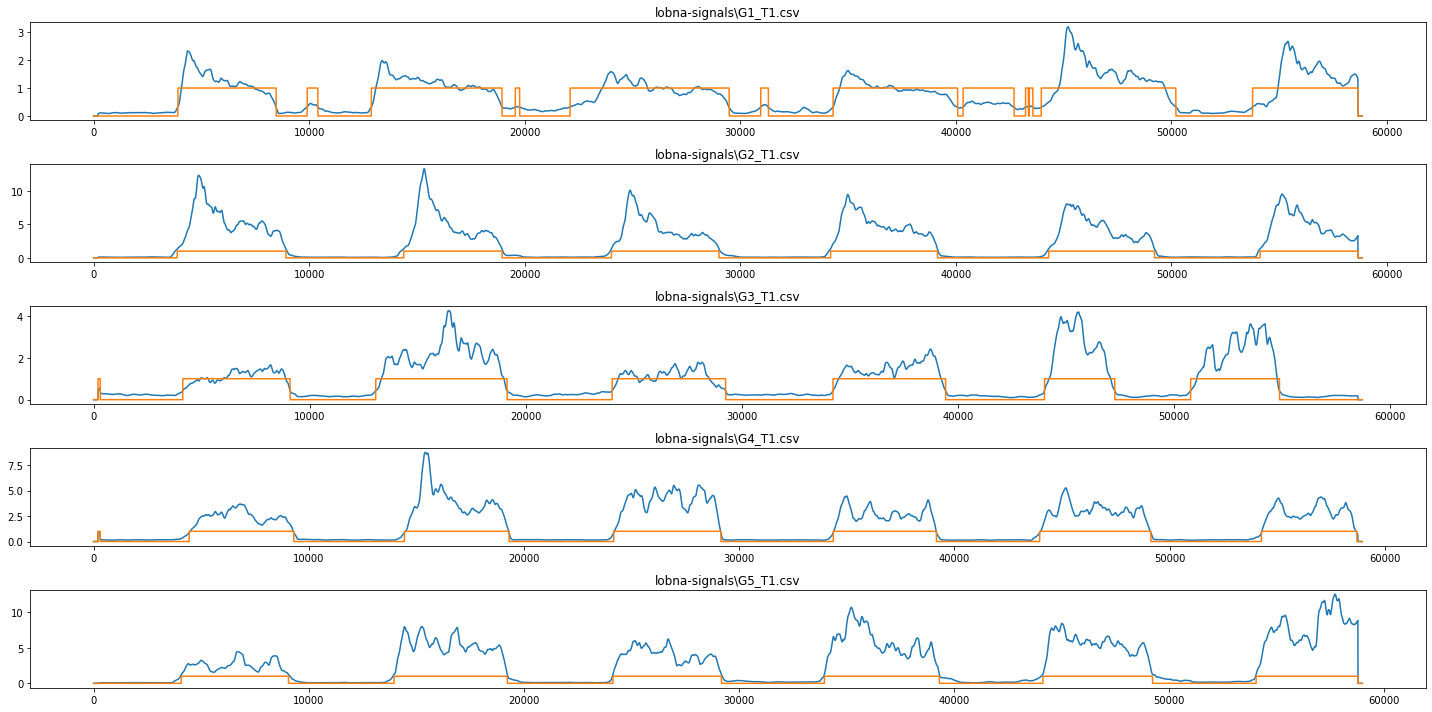

In [102]:
binary_label_sig = [get_binary_label_sig(sig, threshold) for sig, threshold in zip(sm_sig, threshold_10)]
visualize_binary_sigs(binary_label_sig, sm_sig)

### Threshold 7

In [110]:
threshold_level = 7 # % Relative to the average value of the smoothed signal
threshold_level_norm_7 = [normReg(threshold_level, avg, std, sig) for avg, std, sig in zip(avg_sig, std_sig, sm_sig)]

threshold_7 = []
for i in range(len(avg_sig)):
    threshold_7.append(avg_sig[i] + threshold_level_norm_7[i] * std_sig[i])

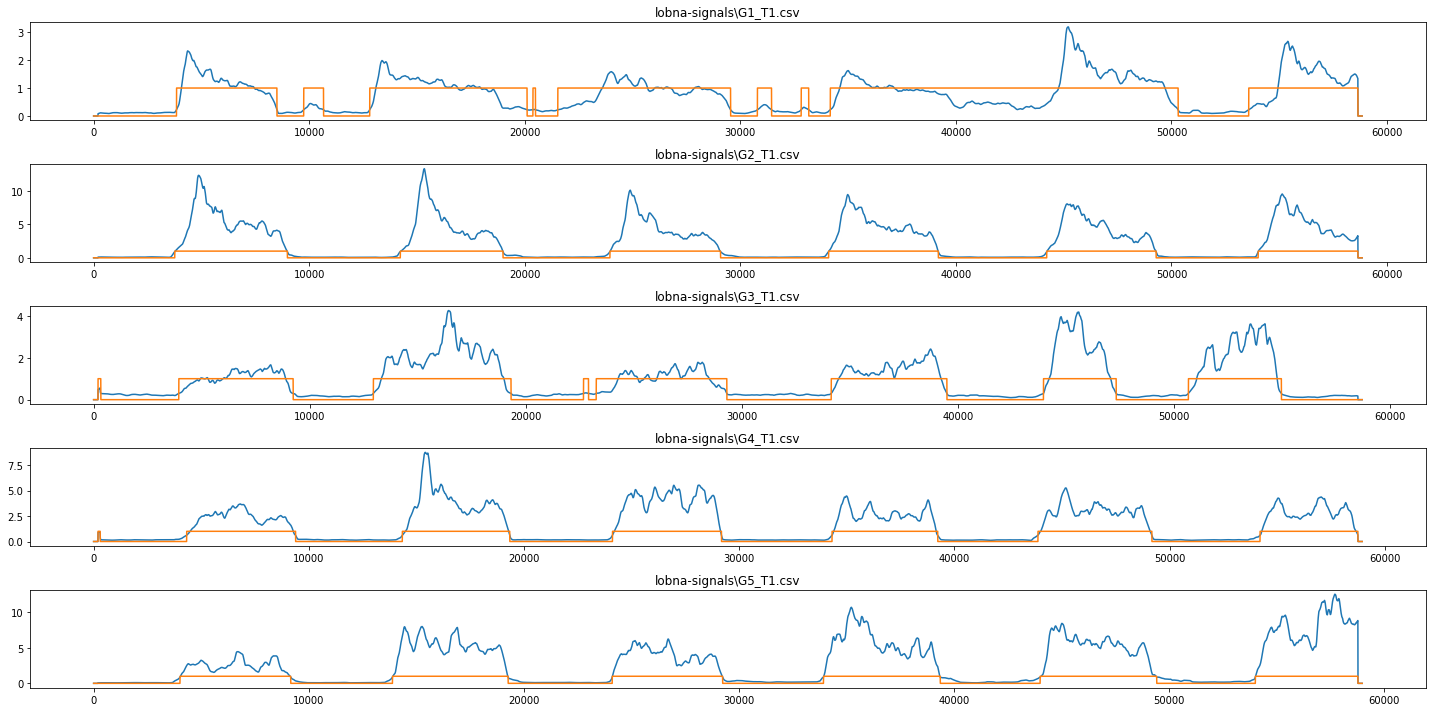

In [111]:
binary_label_sig = [get_binary_label_sig(sig, threshold) for sig, threshold in zip(sm_sig, threshold_7)]
visualize_binary_sigs(binary_label_sig, sm_sig)